# Grandes étapes de l'algorithme (version Fortran77)


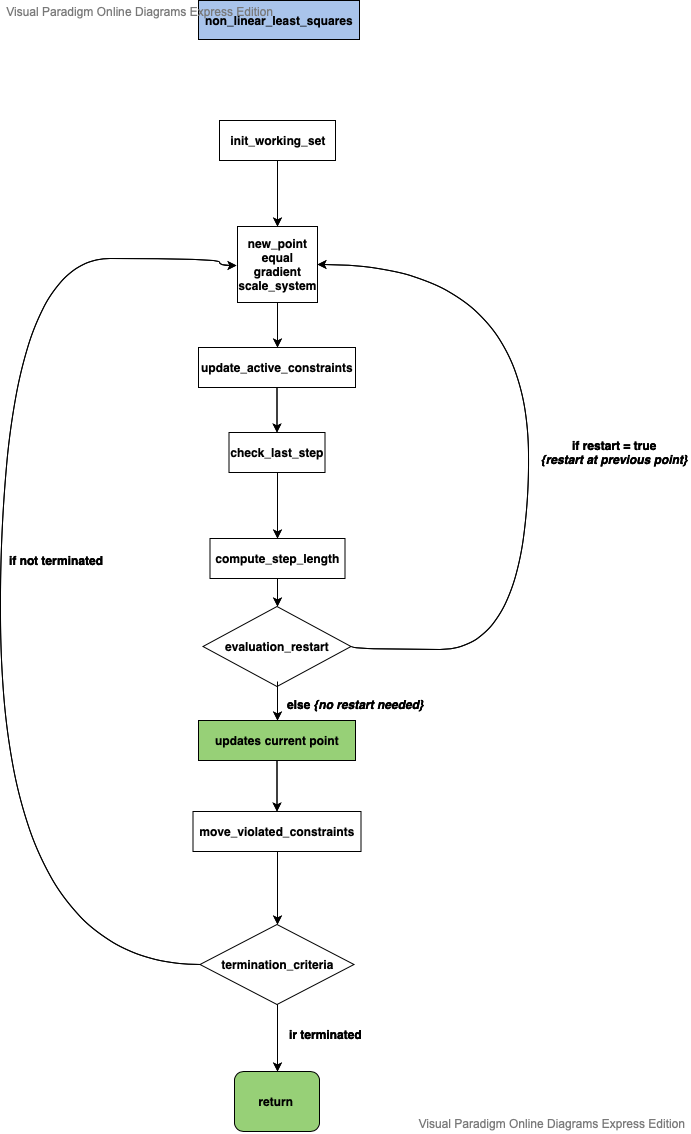


 

# Squelette du main 


In [1]:
# Fonctions appelées dans nlcls_skeleton

function init_work_space(model::Function , x::AbstractArray{Float64}, constraints::Function)
end

function check_termination_criteria(f::Function, x::AbstractArray{Float64})
    return true
end

function new_point(x::AbstractArray{Float64}, f::Function, h::Function)
end

function update_acitve_constraints(model::Function, constraints::Function, x::AbstractArray{Float64},
    latest_step::String)
end

function check_last_step(dx::AbstractArray{Float64}, f::Function, h::Function, lastest_step::String)
end

function compute_steplength(f::Function, x::AbstractArray{Float64}, dx::AbstractArray{Float64}
        , h::Function, psi::Function)
end

function evaluation_restart(f::Function, dx, alpha::Float64, h::Function, latest_step::String)
end

function move_violated_constraints(f::Function, x::AbstractArray{Float64}, h::Function)
end

move_violated_constraints (generic function with 1 method)

In [2]:
# Ne comporte pas (encore) de gestion d'erreurs
# Paramètres à détailler au fur et à lesure de l'avancement

function nlcls_skeleton(model::Function, initial_point::AbstractArray{Float64}, merit_function::Function, 
        constraints::Function)
    # Tests sur les paramètres de départ à rajouter
    
    # Initialisation des paramètres et de l'espace de travail
    
    x, dx, iter = initial_point, zeros(size(initial_point)), 0
    init_workspace(model, x, constraints)
    terminated = check_termination_criteria(model, x)
    while !terminated
        # Mise à jour de l'espace de travail avec le nouveau point
        new_point(x, model, constraints)
        latest_step = "GN"
        
        # Mise à jour des contraintes actives et calcul de la direction Gauss-Newton
        dx = update_active_constraints(model, constraints, x, latest_step)
        
        # Vérification de la dernière étape et recalcul de la direction avec méthode TQR ou Newton si besoin est
        check_last_step(dx, model, constraints, lastest_step)
        
        # Calcul du pas de l'itération (vaut 1 si méthode de Newton utilisée)
        alpha = (latest_step == "Newton" ? 1 : compute_steplength(model, x, dx, constraints, merit_function))
        
        # Si pas de restart : mise à jour du point et des contraintes
        if !evaluation_restart(model, dx, alpha, constraints, latest_step)
            x += alpha * dx
            k += 1
            move_violated_constraints(model, x, constraints)
            terminated = check_termination_criteria(model, x)
        end
    end
    return x, k
end

nlcls_skeleton (generic function with 1 method)

In [4]:
# Reprend la structure du code de l'article

function nlcls_article_skeleton(objective_function, constraints, initial_point, merit_function )
    # vérification qu'il n'y pas d'erreurs dans les paramètres, pb de dimension par ex.
    # à détailler
    
    # initialisation des paramètres
    latest_step, first, phase = "GN", "GN", "normal"
    
    # not sure about p = 0 as an initial value
    k, x, p = 0, initial_point, 0

    
    # initialisation du premier workspace
    init_work_space(objective_function, contraintes);
    terminated = check_termination_criteria(objective_function, x)
    while !terminated
        # updates the system to solve with the new point
        new_point(), equal(), gradient(), scale_system()
        if phase != "Newton"
            while !terminated || !accept_direction(p_k) || phase != "Newton"
                
                # determination of working set and computation of direction are in update_active_constraints
                # computation of GN or subspace minimization search direction
                p_k = update_active_constraints()
                if !terminated
                    compute_penalty_weights(merit_function, x)
                    alpha = compute_step_length(merit_function, x, p)
                    
                    if !accept_direction(p)
                        if phase != "recovery" phase = "sighting" end
                    else
                        x = x + alpha * p
                        k += 1
                        if phase != "recovery" phase = "normal" end
                    end
                    # in this case, check_last_step only analyses the last step
                    # moreover, it doesn't compute SUB nor Newton direction
                    phase = check_last_step(latest_step, phase, first, alpha)
                end
            end
        # use an undamped Newton type method
        else
            count = 0
            newton_failure = false
            while !terminated || !newton_failure
                pn, newton_failure = newton_search_direction(objective_function, x)
                if !terminated
                    x = x + p
                    k += 1
                end
            end
            if newton_failure
                phase, first = "recovery", "GN"
            end
        end
    end
    return x
end
    

nlcls_article_skeleton (generic function with 1 method)

# Direction Gauss-Newton

In [5]:
using LinearAlgebra
using Plots
using Polynomials
using Random

### Gauss-Newton sans contraintes

In [6]:
# solve min [0.5*||Ax - b||^2] using QR decomposition and without constraints
#        x
function gn_direction_unconstrained(A::AbstractMatrix{Float64}, b::AbstractArray{Float64})
    m,n = size(A)
    
    # QR decomposition of matrix A
    decomp_A = qr(A, Val(true))
    P, Q, R = decomp_A.P, decomp_A.Q, decomp_A.R
    d = (transpose(Q) * b)[1:n]
    
    # Index that avoids computation problems with A
    t_acc = maximum([j for j=1:n if max(abs(R[j,j] / R[1,1]), abs(R[1,1])) >= sqrt(eps(Float64))])
    
    # Computation of the GN search direction dx 
    dx = [UpperTriangular(R[1:t_acc, 1:t_acc]) \ d[1:t_acc];zeros(n-t_acc)]
    return P*dx
end

gn_direction_unconstrained (generic function with 1 method)

### Moindres carrés linéaire sans contraintes classique (équations normales)

Vérification que Gauss-Newton sans contraintes donne la même solution qu'un moindre carré linéaire

In [7]:
# solve min [0.5*||Ax - b||^2] with normal equations
#        x 

function lls(A::AbstractMatrix{Float64}, b::AbstractArray{Float64})
    return (transpose(A) * A) \ (transpose(A) * b)
end


A = [1.0 2.4; 5.6 4.0; 12.0 6.0]
b = [12.0; 6.7; 3.0]
x_gn = gn_direction_unconstrained(A,b)
x_normal = lls(A, b)
x_gn

2-element Array{Float64,1}:
 -2.6764772754000417
  5.75974723439619

Fonctions préliminaires

# Calcul du pas

 <b> TODO </b> : Implémentation du pas avec la méthode de l'algorithme originel

### Calcul du pas avec la méthode d'Armijo-Goldstein

In [8]:
# Choix des valeurs de c et τ à approfondir 
# L'article conseille d'utiliser 3 comme borne supérieure du pas

function armijo_step(f::Function, grad_fx::Vector{Float64}, x::Vector{Float64}, dx::Vector{Float64},
        α_upper::Float64 = 3.0, c::Float64 = 0.25, τ::Float64 = 0.5)
    m = - c * dot(grad_fx, dx)
    α = α_upper
    fx, psix = f(x), f(x + α * dx)
    
    while fx - psix <= α * m
        α *= τ
        fx, psix = f(x), f(x + α * dx)
    end
    return α
end

armijo_step (generic function with 4 methods)

### Calcul du pas avec la méthode de Lindstörm-Wedin utilisée dans le code Fortran

Ici, on a $f :
   \begin{array}{l l}
      \mathbb{R} \rightarrow \mathbb{R}^m & \\
      \alpha \rightarrow r(x + \alpha * dx)
   \end{array}
   $
où $r$ est la fonction objectif du problème que l'on cherche à minimiser, $x$ et $dx$ fixés (?) sont respectivement le point courant et la direction de descente calculée à l'aide de la méthode de Gauss-Newton.


<b> Idée </b> : Minimiser $\phi(\alpha) = \dfrac{1}{2} ||r(x + \alpha dx)||^2 = \dfrac{1}{2} ||f(\alpha)||^2$ ,où $r$ est la fonction objectif du problème, par minimisation d'une approximation polynomiale $p$ de $f$.

<b> Paramètres </b>

- $v_0, v_1, v_2$ sont les coefficients du polynôme qui interpole la fonction objectif $f$ au deux (ou trois) points notés $\alpha_{-1}, \alpha_0$ (ou $\alpha_{-1}, \alpha_0, \alpha_1$).

- $\alpha_{best}$ est la valeur de $\alpha$ qui vérifie $s(\alpha_{best}) = \underset{\alpha \in \{\alpha_{-1}, \alpha_0, \alpha_1\}}{min} s(\alpha)$.

- $\alpha_l$ et $\alpha_u$ (avec $\alpha_l < \alpha_u$) sont les bornes de l'intervalle dans lequel doit se trouver la valeur finale du pas $\alpha$.

<b> Fonctions préliminaires </b>

- <b> minrm </b> : Calcule le minimum de la fonction polynomiale $s(\alpha) = \dfrac{1}{2} ||p(\alpha)||^2$ avec $p(\alpha) = v_0 + v_1\alpha + v_2\alpha^2$, $v_k \in \mathbb{R}^m$ pour $k \in \{1, 2, 3\}$.
- <b> parameters_rm </b> : Calcule $\hat{\alpha}$ et $\hat{\beta}$ les deux minimiseurs de $s$ ($\alpha$ étant le minimiseur le plus pertinent).

- <b> bounds! </b> : Réajuste $\hat{\alpha}$ dans le cas où il ne se situe pas dans l'intervalle $[\alpha_l,\alpha_u]$ en remplaçant sa valeur par celle de la borne la plus proche.

- <b> newton_raphson </b> : Résout $s'(\alpha) = 0$ par la méthode de Newton-Raphson dans le cas où le critère de convergence de la résolution analytique $s''(\alpha_{best}) * \eta < 2*D_m*h_m$ n'est pas respecté.

- <b> one_root, two_roots </b> : Renvoient la/les racines réelles de $s'(\alpha) = 0$ si le critère ci-dessus pour la résolution analytique est respecté. Pour <b>two_roots</b>, $\alpha$ est la meilleure des deux racines pour le problème. 

<b> Paramètres </b>

- $v_0, v_1, v_2$ sont les coefficients du polynôme qui interpole la fonction objectif $f$ au deux (ou trois) points notés $\alpha_{-1}, \alpha_0$ (ou $\alpha_{-1}, \alpha_0, \alpha_1$).

- $\alpha_{best}$ est la valeur de $\alpha$ qui vérifie $s(\alpha_{best}) = \underset{\alpha \in \{\alpha_{-1}, \alpha_0, \alpha_1\}}{min} s(\alpha)$.

- $\alpha_l$ et $\alpha_u$ (avec $\alpha_l < \alpha_u$) sont les bornes de l'intervalle dans lequel doit se trouver la valeur finale du pas $\alpha$.

In [75]:
function parameters_rm(v0::Vector, v1::Vector, v2::Vector, α_best::Float64,
        ds::Polynomial{Float64}, dds::Polynomial{Float64})
    dds_best = dds(α_best)
    η, d = 0.1, 1.
    h0 = abs(ds(α_best) / dds_best )
    Dm = abs(6*dot(v1,v2) + 12*α_best*norm(v2)^2) + 24*h0*norm(v2)^2
    hm = max(h0, 1)

    # s'(α) = 0 is solved analytically
    if dds_best * η < 2 * Dm * hm
        
        # If t = α+a1 solves t^3 + b*t + c = O then α solves s'(α) = 0
        (a3, a2, a1) = coeffs(ds) / (2 * norm(v2)^2)
        
        b = a2 - (a1^2) / 3
        c = a3 - a1 * a2/3 + 2*(a1/3)^3
        d = (c/2)^2 + (b/3)^3
        # Two interisting roots
        if d < 0
            α_hat, β_hat = two_roots(b, c, d, a1, α_best)
        
        # Only one root is computed     
        else
            α_hat = one_root(c, d, a1)
        end
    
    # s'(α) = 0 is solved using Newton-Raphson's method
    else
        α_hat = newton_raphson(α_best::Float64, Dm::Float64, ds, dds)
    end
    
    # If only one root computed
    if d >= 0 
        β_hat = α_hat 
    end
    return α_hat, β_hat
end

function bounds(α_l::Float64, α_u::Float64, α::Float64, s::Polynomial{Float64})
    α = min(α, α_u)
    α = max(α, α_l)
    return α, s(α)
end

function newton_raphson(α_best::Float64, Dm::Float64, ds::Polynomial{Float64}, dds::Polynomial{Float64})
    α, newtonstep = α_best, 0
    ε, error = 1e-4, 1.
    while error > ε || newtonstep < 3
        c = dds(α)
        h = -ds(α) / c
        α += h
        error = (2 * Dm * h^2) / abs(c)
        newtonstep += 1
    end
    return α
end

function one_root(c::Float64, d::Float64, a::Float64)
    arg1, arg2 = -c/2 + sqrt(d), -c/2 - sqrt(d)
    return cbrt(arg1) + cbrt(arg2) - a/3
end

function two_roots(b::Float64, c::Float64, d::Float64, a::Float64, α_best::Float64)
    φ = acos(abs(c/2) / (-b/3)^(3/2))
    t = (c <= 0 ? 2*sqrt(-b/3) : -2*sqrt(-b/3))
    
    # β1 is the global minimizerof s(α. 
    # If d is close to zero the root β1 is stable while β2 and β3 become unstable
    β1 = t * cos(φ/3) - a/3
    β2 = t * cos((φ + 2 * π) / 3) - a/3
    β3 = t * cos((φ + 4 * π) / 3) - a/3
    
    # Sort β1, β2 and β3 so that β1 <= β2 <= β3
    β1, β2, β3 = sort([β1, β2, β3])
    
    #β1 or β3 are now the roots of interest
    α, β = (α_best <= β2 ? (β1, β3) : (β3, β1))
    return α, β
end  

function minrm(v0::Vector, v1::Vector, v2::Vector, α_best::Float64, α_l::Float64 = 1e-3, α_u::Float64 = 3.)
    
    s = Polynomial([0.5*norm(v0)^2, dot(v0,v1), dot(v0,v2) + 0.5*norm(v1)^2, dot(v1,v2), 0.5*norm(v2)^2])
    ds = derivative(s)
    dds = derivative(ds)
    α_hat, β_hat = parameters_rm(v0, v1, v2, α_best, ds, dds)
    sα, sβ = s(α_hat), s(β_hat)
    α_old = α_hat
    α_hat, sα = bounds(α_l, α_u, α_hat, s)
    if α_old == β_hat
        β_hat, sβ = α_hat, s(α_hat)
    else
        β_hat, sβ = bounds(α_l, α_u, β_hat, s)
    end
    return α_hat, sα, β_hat, sβ
end



minrm (generic function with 3 methods)

<b> Fonction d'interpolation polynomiale </b>

(à voir si on peut utiliser une fonction d'interpolation du module Polynomials) 

- <b> coeffs_interpolation_3p </b> Calcule et renvoie les coefficients de l'interpolation polynomiale de degré 2 de la fonction objectif vectorielle $f$ passant par les trois points $x_0, x_1, x_2$ suivante  :<p> $ p(\alpha) = f(x_0) + (\alpha - x_0)f[x_0, x_1] + (\alpha - x_0)(\alpha - x_1)f[x_0, x_1, x_2]$ </p> où les coefficients sont calculés à l'aide des différences divisées : $[x_j, x_k] = \dfrac{f(x_k)-f(x_j)}{x_k - x_j}$ et $f[x_i, x_j, x_k] = \dfrac{f[x_j, x_k]-f[x_j, x_i]}{x_k - x_i}$. Pour $(x_0, \ldots, x_n)$ et $y = (f(x_0), \ldots, f(x_n))$ en entrée, <b> divided_differences </b> renvoie le vecteur des différences divisées
 $(f[x_0], f[x_0, x_1], \ldots, f[x_0, \ldots, x_n])$
 
- <b> coeffs_interpolation_2p </b> Idem mais l'interpolation passe ici par deux points : $0$ et $\alpha_0$ donné. Ici, la formule de $p$ est directement donnée par : <p>$ p(\alpha) = f(0) + \alpha_0f[0,0] + \alpha^2f[0,0, \alpha_0]$</p> avec $f[0,0] = \nabla f(0)$ et $f[0,0, \alpha_0]$ donné par la formule des différences divisées ci-dessus.

In [74]:
function coeff_interpolation_3p(f::Function, x::Vector)
    function divided_differences(x::Vector, y::Vector)
        n, d = length(x), y
        for i=1:n
            for j=n:-1:i+1
                d[j] = (d[j] - d[j-1]) / (x[j] - x[j-i])
            end
        end
        return d
    end
    divdiff = divided_differences(x, map(f, x))
    v0 = divdiff[1] - x[1] * divdiff[2] + x[1] * x[2] * divdiff[3]
    v1 = divdiff[2] - (x[1] + x[2]) * divdiff[3]
    v2 = divdiff[3]
    return (v0, v1, v2)
end

function coeff_interpolation_2p(f::Function, gradf_0::Vector, α::Float64)
    v0 = f(0.)
    v1 = gradf_0
    v2 = (((f(α) - v0) / α) - gradf_0) / α
    return (v0, v1, v2)
end


coeff_interpolation_2p (generic function with 1 method)

<b> Algorithme de recherche du pas </b>

Calcule le pas avec plusieurs itérations de la méthode d'interpolation polynomiale décrite par la fonction <b>minrm</b> . Si le pas calculé n'est pas bon ou trop petit (critères à définir précisément), on calcule le pas d'Armijo-Goldstein.

In [73]:
function steplength_unconstrained(r::Function, jacobian_r::Function, x::Vector, dx::Vector, 
        α0::Float64, αl::Float64 = 1e-3, αu::Float64 = 3.)
    # Definition of parameters and intermiediate functions
    f = α::Float64 -> r(x + α * dx)
    
    ∇f = α::Float64 -> jacobian_r(x + α * dx) * dx
        
    n = length(x)
    τ, γ = 0.25, 0.4
    ϕ = α::Float64 -> 0.5 * norm(f(α))^2
    jac_x = jacobian_r(x)
    ∇f0 = ∇f(0.)
    dϕ0 = dot(dx, transpose(jac_x) * jac_x * dx + transpose(jac_x) * r(x))
    
    is_acceptable = α::Float64 -> (ϕ(α) <= ϕ(0.) + τ * dϕ0 * α) || (ϕ(α) <= γ * ϕ(0.))
    
    function best_alpha(list_alpha::Vector, s::Function)
        minimum(Dict(s(t) => t for t in list_alpha)).second
    end
    
    function progress_check(s_star::Float64, ϕ::Function, αk::Float64, αk_1::Float64, η::Float64 = 0.3)
       # ϕk = ϕ(αk)
       # return s_star <= η * ϕk && ϕk <= η * ϕ(αk_1)
        return true
    end
    
    k, α_1 = 0, 0.
    
    # Find minimum of parabola interpolating f at 0 and α0
    (v0, v1, v2) = coeff_interpolation_2p(f, ∇f0, α0)
    αbest = best_alpha([0, α0], t::Float64 -> 0.5*norm(v0 + v1*t + v2*t^2)^2)
    α_star, s_star = minrm(v0, v1, v2, αbest, αl, αu)
    
    if is_acceptable(α0)
        satisfied = progress_check(s_star, ϕ, α0, α_1)
        
        if !satisfied α1 = α_star end
        while !satisfied
            if k > 0 α_1, α0, α1 = α0, α1, α_star end
                
            (v0, v1, v2) = coeff_interpolation_3p(f, [α_1, α0, α1])
            α_best = best_alpha([α_1, α0, α1], t::Float64 -> 0.5*norm(v0 + v1*t + v2*t^2)^2)
            α_star, s_star = minrm(v0, v1, v2, α_best, αl, αu)
            satisfied = progress_check(s_star, ϕ, α1, α0)
            println(satisfied)
            if k == 0 k += 1 end
        end
        if k == 0 return α0 end
        
    else
        α1 = α_star
        if is_acceptable(α1)
            if ϕ(0.) <= ϕ(α0)
                (v0, v1, v2) = coeff_interpolation_2p(f, ∇f0, α1)
                α_best = best_alpha([0, α1], t::Float64 -> 0.5*norm(v0 + v1*t + v2*t^2)^2)
                α_star, s_star = minrm(v0, v1, v2, α_best, αl, αu)
                α0 = 0.
            else
                (v0, v1, v2) = coeff_interpolation_3p(f, [α_1, α0, α1])
                α_best = best_alpha([α_1, α0, α1], t::Float64 -> 0.5*norm(v0 + v1*t + v2*t^2)^2)
                α_star, s_star = minrm(v0, v1, v2, α_best, αl, αu)
                satisfied = progress_check(s_star, ϕ, α1,α0)
                if !satisfied α1 = α_star end
                
                while !satisfied
                    if k > 0 α_1, α0, α1 = α0, α1, α_star end
                
                    (v0, v1, v2) = coeff_interpolation_3p(f, [α_1, α0, α1])
                    α_best = best_alpha([α_1, α0, α1], t::Float64 -> 0.5*norm(v0 + v1*t + v2*t^2)^2)
                    α_star, s_star = minrm(v0, v1, v2, α_best, αl, αu)
                    satisfied = progress_check(s_star, ϕ, α1, α0)
                    if k == 0 k += 1 end
                end
            end
        else
            α1 = armijo_step(f, ∇f(x), x, dx, α1)
            
            
            # Rajouter "α1 est trop petit" comme condition d'arrêt du while
            while !is_acceptable(α1)
                α1 = armijo_step(f, ∇f(x), x, dx, α1)
            end
        end
            
        
    end
    return best_alpha([α0, α1], ϕ)
end

steplength_unconstrained (generic function with 3 methods)

### Calcul de direction de descente par la méthode de Newton

In [82]:
# Calcule la direction de Newton

function newton_unconstrained(grad_fx::Vector, H::Matrix)
    return H \ grad_fx
end

newton_unconstrained (generic function with 1 method)

# Résolution d'un problème de moindres carrés non linéaire sans contraintes

Paramètres :
- $(t, y)$ : données de départ à partir desquelles on ajuste le modèle
- $ initial\_point$ : point de départ de la boucle principale
- $r$ : fonction vectorielle des résidus comportant les différences entre les sorties observées et les prédictions du modèle
- $jacobian\_r$ : matrice jacobienne de la fonction $r$

In [104]:
function nlucls(t::AbstractArray{Float64}, y::AbstractArray{Float64}, r::Function, 
        initial_point::AbstractArray{Float64}, jacobian_r::Function, with_step_computation::Bool = true)
    
    x = initial_point
    jac_x = jacobian_r(x)
    dx = zeros(length(x))
    
    grad_fx = transpose(jac_x) * jac_x * dx + transpose(jac_x) * r(x)
    iter = 0
    while norm(grad_fx) > 1e-6 && iter < 50
        # Computation of the GN-search direction 
        dx = gn_direction_unconstrained(jacobian_r(x), -r(x))
        
        # Computation of the steplength using inteprolation method
        α = (with_step_computation ? steplength_unconstrained(r, jacobian_r, x, dx, 1.) : 1)
        
        # Update current point
        x += α * dx
        
        # Update of jacobian and gradient
        jac_x = jacobian_r(x)
        grad_fx = transpose(jac_x)*jac_x*dx + transpose(jac_x)*r(x)
        iter += 1
    end
    println("$iter itérations")
    
    return x
end

nlucls (generic function with 2 methods)

7 itérations
[0.3618366954234484, 0.556265449723856]


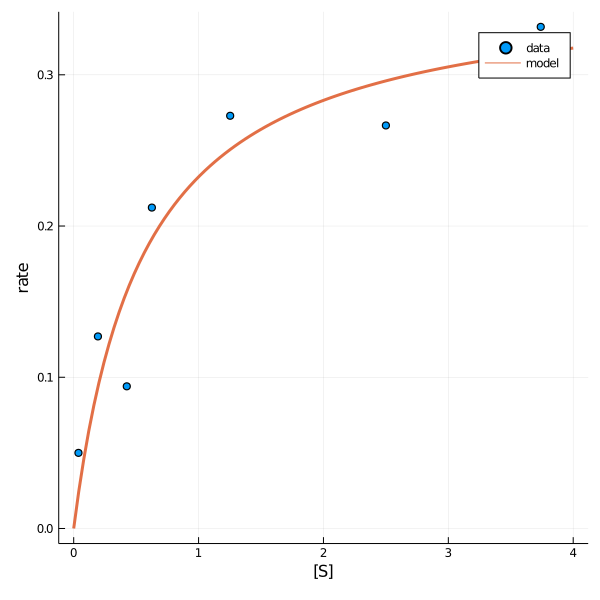

In [105]:
# Exemple pré-défini trouvé sur la page wikipédia de l'algorithme de Gauss-Newton

S = [0.038;0.194;0.425;0.626;1.253;2.500;3.740]
rate = [0.050;0.127;0.094;0.2122;0.2729;0.2665;0.3317]
function model(x::Vector, t::Float64)
    return (x[1] * t) / (x[2] + t)
end
function residuals(x::AbstractArray{Float64})
    return [rate[i] - model(x, S[i]) for i=1:7]
end
function jacobian_r(x::AbstractArray{Float64})
    jac1 = [-S[i] / (x[2] + S[i]) for i=1:7]
    jac2 = [(x[1]*S[i]) / (x[2]+S[i])^2 for i=1:7]
    return hcat(jac1, jac2)
end

x = nlucls(S, rate, residuals, [0.9;0.2], jacobian_r, true)
println(x)
t = range(0,4,length=100)
scatter(S,rate, label = "data")
plot!(t, [model(x, t[i]) for i=1:length(t)], lw=3, label = "model")
plot!(xlabel = "[S]", ylabel = "rate")





9 itérations
[0.5080744538967658, 1.9948270743780434, 2.106653826582792]

Erreur moyenne sur x de 0.039967068700504815 % 



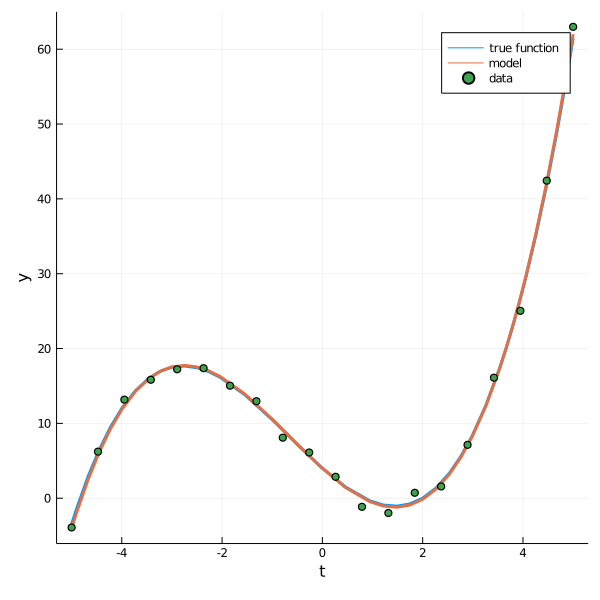

In [125]:
function f(x::Vector, t::Float64)
    return x[1] * t^3 + (t - x[2])^2 - x[3] * t
end

function true_f(t::Float64)
    return 0.5t^3 + (t-2)^2 - 2t
end
t = range(-5, 5, length=20)
ϵ = randn(20) # Perturbation
y = map(true_f, t) + ϵ # Données générées

function r(x::Vector)
    return y - map(t -> f(x, t), t)
end

function jac_r(x::Vector)
    jac1 = map(t::Float64 -> -2 * x[1] * t^3, t)
    jac2 = map(t::Float64 -> 2 * (t - x[2]), t)
    jac3 = map(t::Float64 -> t, t)
    return hcat(jac1, jac2, jac3)
end

x = nlucls(t, y, r,[1., 1., 1.], jac_r, true)
erreur = sum(map(abs, x - [0.5, 2., 2.])) / 3
println(x, "\n")    

println("Erreur moyenne sur x de $erreur % \n")
plot(true_f, label = "true function", lw = 3)
plot!(t -> f(x, t), label = "model", lw = 3)
scatter!(t, y, label = "data")
plot!(xlabel = "t", ylabel = "y")